In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import copy

### Set up directory
import sys
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "3,4,5"
from pathlib import Path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

from tqdm import tqdm

import gymnasium as gym

from llama import get_model_and_tokenizer

ModuleNotFoundError: No module named 'pandas'

In [ ]:
model, tokenizer = get_model_and_tokenizer('7b')

getting tokenizer


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
get_model_and_tokenizer

<function llama.get_model_and_tokenizer(model)>

In [2]:
print(True)

True


In [3]:
from rl_utils import calculate_multiPDF_llama3, gym_generate_random_policy, load_offline_dataset, make_RL_time_serie, icl_prediction, compute_statistics, to_plot_stats 
from utils import create_ns, completion_matrix, completion_matrix_ot_breg, bins_completion, plot_matrix

In [4]:
from transformers import LlamaForCausalLM, AutoTokenizer
from data.serialize import serialize_arr, deserialize_str, SerializerSettings

In [5]:
class ICLTrainer:
    def __init__(self, env: gym.Env, model: LlamaForCausalLM, tokenizer: AutoTokenizer):
        self.env = env
        self.model = model
        self.tokenizer = tokenizer

        self.n_observations = env.observation_space.shape[0]
        self.n_actions = env.action_space.shape[0]

        self.rescaling_min = {}
        self.rescaling_max = {}

        self.in_context_series = {}
        self.statistics = {}
        self.kv_cache = {}

        self.transition_matrix_baseline = {}
        self.transition_matrix_NN = {}
        self.transition_matrix_OT = {}
        
    def update_context(self, X: np.array, context_length: int = 100):
        self.context_length = context_length
        for dim in tqdm(range(self.n_observations), desc="update_context / state dim"):
            episode_time_series = X[:context_length, dim].reshape((-1,1))
            
            time_series = episode_time_series.flatten()
            mean_series = copy.copy(time_series)
            std_series = np.zeros_like(mean_series)
            
            # ------------------ serialize_gaussian ------------------
            settings = SerializerSettings(base=10, prec=2, signed=True, time_sep=',', bit_sep='', minus_sign='-', fixed_length=False, max_val = 10)
            time_series = np.array(time_series)
            ### Final range is from 0.15 to 0.85
            rescale_factor = 7.0
            up_shift = 1.5

            self.rescaling_min[dim] = time_series.min()
            self.rescaling_max[dim] = time_series.max()
        
            rescaled_array = (time_series-time_series.min())/(time_series.max()-time_series.min()) * rescale_factor + up_shift
            rescaled_true_mean_arr = (np.array(mean_series)-time_series.min())/(time_series.max()-time_series.min()) * rescale_factor + up_shift
            rescaled_true_sigma_arr = np.array(std_series)/(time_series.max()-time_series.min()) * rescale_factor
            
            full_series = serialize_arr(rescaled_array, settings)

            # Save the generated data to a dictionary
            series_dict = {
                'full_series': full_series,
                'rescaled_true_mean_arr': rescaled_true_mean_arr,
                'rescaled_true_sigma_arr': rescaled_true_sigma_arr,
                'time_series': time_series,
            }
            self.in_context_series[dim] = series_dict
        return self.in_context_series
    
    def icl(self, temperature: float = 1.0, n_states: int = 1000, use_cache: bool = True):
        predictions = np.zeros((self.context_length, self.n_observations))
        for dim in tqdm(range(self.n_observations), desc="icl / state dim"):
            PDF_list, probs, kv_cache = calculate_multiPDF_llama3(
                self.in_context_series[dim]['full_series'],
                model=self.model,
                tokenizer=self.tokenizer,
                n_states=n_states,
                temperature=temperature,
                use_cache=use_cache,
            )
            self.in_context_series[dim]['PDF_list'] = PDF_list
            self.in_context_series[dim]['probs'] = probs.detach().cpu().numpy()
            self.kv_cache[dim] = kv_cache

            ts_min = self.rescaling_min[dim]
            ts_max = self.rescaling_max[dim]
            
            for timestep in range(len(PDF_list)):
                PDF = PDF_list[timestep]
                PDF.compute_stats()
            
                # Calculate the mode of the PDF
                next_state = PDF.mode * (ts_max - ts_min) + ts_min
                predictions[timestep, dim] = next_state
        
        return predictions

    def compute_statistics(self,):
        for dim in tqdm(range(self.n_observations), desc="statistics / state dim"):
            self.statistics[dim] = compute_statistics(
                series_dict=self.in_context_series[dim],
            )
        return self.statistics

    def build_tranistion_matrices(self, reg: float = 5e-3):
        for dim in range(self.n_observations):
            comma_locations = np.sort(np.where(np.array(list(self.in_context_series[dim]['full_series'])) == ',')[0])
            ns = create_ns(self.in_context_series[dim]['full_series'], comma_locations)
            bins_ = bins_completion(self.in_context_series[dim]['PDF_list'])

            p_ot, _ = completion_matrix_ot_breg(bins_,ns,statistics['discrete_BT_loss'], reg=reg)
            p_nn, _ = completion_matrix(bins_,ns,statistics['discrete_BT_loss'])

            self.transition_matrix_NN[dim] = p_nn
            self.transition_matrix_OT[dim] = p_ot
        return self.transition_matrix_NN, self.transition_matrix_OT

    def predict_llm(self, state: np.array, temperature: float = 1.0):
        """
        1. Append the state to the time series.
        2. Redo prediction using the updated time series.
        3. Get PDF of the last prediction.
        4. Return the mode as the predicted next state.
        """
        next_states = np.zeros(self.n_observations)
    
        for dim in tqdm(range(self.n_observations), desc="predict_llm / state dim"):
            # Append the current state to the time series
            current_series = self.in_context_series[dim]['time_series']
            updated_series = np.append(current_series, state[dim])

            mean_series = copy.copy(updated_series)
            std_series = np.zeros_like(mean_series)
    
            # Rescale the updated series
            rescale_factor = 7.0
            up_shift = 1.5
            ts_min = self.rescaling_min[dim]
            ts_max = self.rescaling_max[dim]
            rescaled_series = (updated_series - ts_min) / (ts_max - ts_min) * rescale_factor + up_shift
        
            rescaled_true_mean_arr = (np.array(mean_series)-ts_min) / (ts_max - ts_min) * rescale_factor + up_shift
            rescaled_true_sigma_arr = np.array(std_series)/(ts_max - ts_min) * rescale_factor
    
            # Serialize the updated series
            settings = SerializerSettings(base=10, prec=2)
            full_series = serialize_arr(rescaled_series, settings)
            
            # Redo prediction
            PDF_list, probs, kv_cache = calculate_multiPDF_llama3(
                full_series,
                model=self.model,
                tokenizer=self.tokenizer,
                n_states=1000,
                temperature=temperature,
                use_cache=True,
                kv_cache_prev=self.kv_cache[dim]
            )
            
            # Get the PDF of the last prediction
            last_PDF = PDF_list[-1]
            last_PDF.compute_stats()
            
            # Calculate the mode of the PDF
            next_state = last_PDF.mode * (ts_max - ts_min) + ts_min
            next_states[dim] = next_state

            # update internal attributes
            self.in_context_series[dim]['full_series'] = full_series
            self.in_context_series[dim]['rescaled_true_mean_arr'] = rescaled_true_mean_arr
            self.in_context_series[dim]['rescaled_true_sigma_arr'] = rescaled_true_sigma_arr
            self.in_context_series[dim]['time_series'] = updated_series
            self.in_context_series[dim]['PDF_list'] = PDF_list
            self.in_context_series[dim]['probs'] = probs.detach().cpu().numpy()
            self.kv_cache[dim] = kv_cache
        
        return next_states

    def predict_long_horizon_llm(self, state: np.array, h: int, temperature: float = 1.0):
        """
        Predict h steps into the future by appending the previous prediction to the time series.
        """
        future_states = np.zeros((h, self.n_observations))
        current_state = state.copy()

        for step in tqdm(range(h), desc="prediction horizon"):
            next_state = self.predict_llm(current_state, temperature)
            future_states[step] = next_state
            current_state = next_state  # Use the predicted state as the new current state for the next step

        return future_states
    
    # def predict_markov_chain(self, state: np.array, action: np.array, mode: str = 'nn', sampling: str = 'mode'):
    
    # def predict_long_horizon_markov_chain(self, state: np.array, action: np.array, horizon: int = 2):

In [6]:
env = gym.make('HalfCheetah')
icl_trainer = ICLTrainer(env=env, model=model, tokenizer=tokenizer)

/home/abenechehab/miniforge3/envs/LLMICL/lib/python3.9/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `HalfCheetah-v4` instead of the unversioned environment `HalfCheetah`.
  logger.warn(


NameError: name 'model' is not defined

statistics / state dim: 100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 128.97it/s]


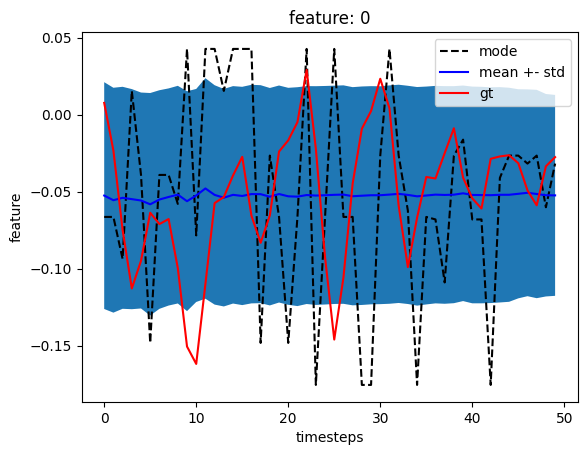

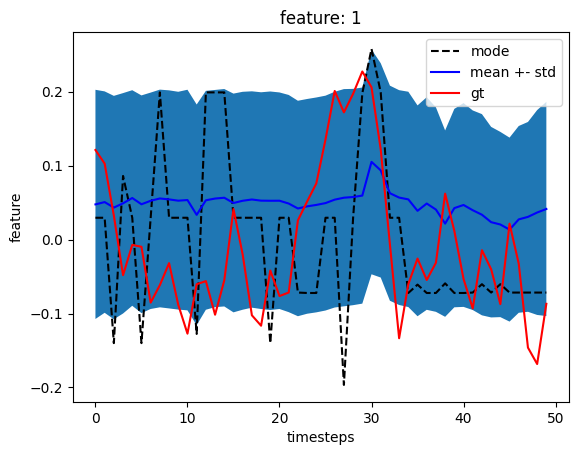

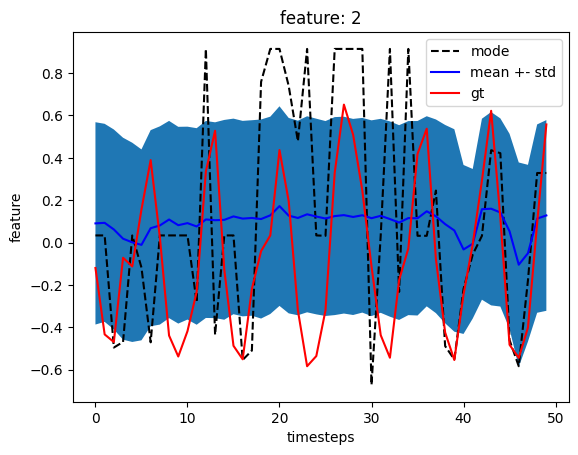

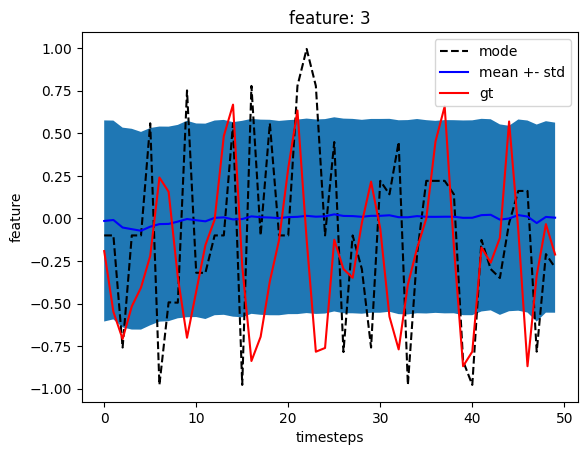

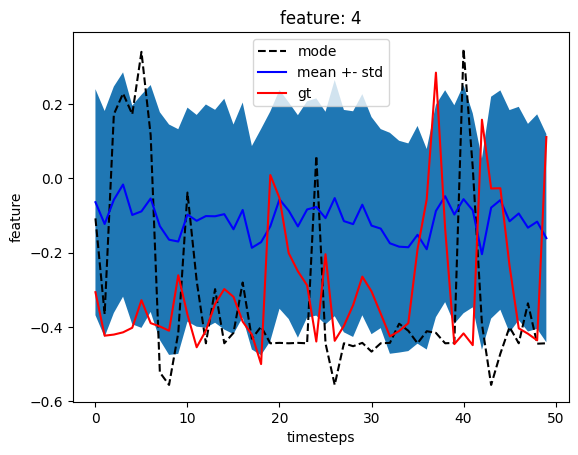

KeyboardInterrupt: 

In [11]:
data_path = "/home/abenechehab/d4rl_halfcheetah/d4rl_expert_80k_20k/X_test.csv"
X, _, n_observations, n_actions = load_offline_dataset(path=data_path)

context_length = 50
rescale_factor = 7.0
up_shift = 1.5
icl_trainer.update_context(X=X, context_length=context_length)

icl_trainer.icl()

series_dict = icl_trainer.in_context_series
statistics = icl_trainer.compute_statistics()

for dim in range(n_observations):
    groundtruth = X[1:context_length+1, dim].flatten()
    
    ts_max = icl_trainer.rescaling_max[dim]
    ts_min = icl_trainer.rescaling_min[dim]
    # -------------------- Useful for Plots --------------------
    mode_arr = ((statistics[dim]['mode_arr'].flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min 
    mean_arr = ((statistics[dim]['mean_arr'].flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min
    sigma_arr = (statistics[dim]['sigma_arr'].flatten() / rescale_factor) * (ts_max - ts_min)

    # -------------------- Trajectory visualization --------------------
    x = np.arange(mean_arr.shape[0])
    plt.figure()
    plt.plot(x, mode_arr, 'k--',label='mode')
    plt.plot(x, mean_arr, label='mean +- std', color='blue')
    plt.fill_between(x=x, y1=mean_arr-sigma_arr, y2=mean_arr+sigma_arr)
    plt.plot(x, groundtruth, label='gt', color='red')
    plt.title(f"feature: {dim}")
    plt.xlabel("timesteps")
    plt.ylabel("feature")
    plt.legend()
    # plt.savefig(f"RL_figures/traj_{columns[feature] if all_dim else columns[dim]}_{policy}.png")
    plt.show()

In [ ]:
data_path = "/home/abenechehab/d4rl_halfcheetah/d4rl_expert_80k_20k/X_test.csv"
X, _, n_observations, n_actions = load_offline_dataset(path=data_path)

prediction_horizon = 10
context_length = 200
rescale_factor = 7.0
up_shift = 1.5
icl_trainer.update_context(X=X, context_length=context_length)

icl_trainer.icl()

# extract last prediction
statistics = icl_trainer.compute_statistics()

last_prediction = np.zeros((n_observations, ))
for dim in range(n_observations):
    ts_max = icl_trainer.rescaling_max[dim]
    ts_min = icl_trainer.rescaling_min[dim]
    # -------------------- Useful for Plots --------------------
    mode_arr = ((statistics[dim]['mode_arr'].flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min 
    last_prediction[dim] = mode_arr[-1]

# multi-horizon pediction
icl_trainer.predict_long_horizon_llm(state=last_prediction, h=prediction_horizon, temperature=1.0)

series_dict = icl_trainer.in_context_series
statistics = icl_trainer.compute_statistics()

for dim in range(n_observations):
    groundtruth = X[1:context_length+1+prediction_horizon, dim].flatten()
    size_all = len(groundtruth)
    
    ts_max = icl_trainer.rescaling_max[dim]
    ts_min = icl_trainer.rescaling_min[dim]
    # -------------------- Useful for Plots --------------------
    mode_arr = ((statistics[dim]['mode_arr'].flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min 
    mean_arr = ((statistics[dim]['mean_arr'].flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min
    sigma_arr = (statistics[dim]['sigma_arr'].flatten() / rescale_factor) * (ts_max - ts_min)

    # -------------------- Trajectory visualization --------------------
    x = np.arange(mean_arr.shape[0])
    plt.figure()
    plt.plot(x, mode_arr, 'k--',label='mode')
    # single step
    plt.plot(x[:-prediction_horizon], mean_arr[:-prediction_horizon], label='mean +- std', color='blue')
    plt.fill_between(
        x=x[:-prediction_horizon], 
        y1=mean_arr[:-prediction_horizon]-sigma_arr[:-prediction_horizon], 
        y2=mean_arr[:-prediction_horizon]+sigma_arr[:-prediction_horizon],
        alpha=.3,
        color='blue'
    )
    # multi_step
    plt.plot(x[-prediction_horizon:], mean_arr[-prediction_horizon:], label='mean +- std', color='orange')
    plt.fill_between(
        x=x[-prediction_horizon:], 
        y1=mean_arr[-prediction_horizon:]-sigma_arr[-prediction_horizon:], 
        y2=mean_arr[-prediction_horizon:]+sigma_arr[-prediction_horizon:],
        alpha=.3,
        color='orange'
    )

    plt.plot(x, groundtruth, label='gt', color='red')
    plt.title(f"feature: {dim}")
    plt.xlabel("timesteps")
    plt.ylabel("feature")
    plt.legend()
    # plt.savefig(f"RL_figures/traj_{columns[feature] if all_dim else columns[dim]}_{policy}.png")
    plt.show()

predict_llm / state dim:  53%|███████████████████████████████████████████▉                                       | 9/17 [00:41<00:36,  4.58s/it]

In [32]:
init_state, _ = env.reset()
icl_trainer.predict_llm(state=init_state, temperature=1.0)

' 5 0 0 , 4 0 1 , 2 3 1 , 2 1 2 , 4 2 8 , 4 0 5 , 5 5 1 , 6 7 8 , 4 8 0 , 2 2 8 , 1 7 4 , 2 3 9 , 3 4 0 , 6 4 9 , 7 5 3 , 3 9 7 , 2 0 2 , 1 6 7 , 3 4 8 , 4 4 5 , 4 8 5 , 7 0 4 , 5 7 3 , 2 9 3 , 1 5 0 , 1 7 6 , 2 9 3 , 6 4 5 , 8 2 0 , 7 4 3 , 6 0 0 , 4 0 5 , 2 2 9 , 1 7 1 , 3 7 0 , 4 5 1 , 6 9 4 , 7 5 8 , 4 2 4 , 2 3 6 , 1 6 5 , 3 3 4 , 4 6 2 , 6 2 6 , 8 0 4 , 5 3 1 , 2 0 5 , 1 7 1 , 2 4 9 , 5 1 7 , 7 6 9 , 8 1 1 , 4 7 3 , 1 5 5 , 1 7 8 , 2 8 3 , 4 9 8 , 7 6 6 , 6 5 1 , 2 8 3 , 1 6 1 , 2 2 4 , 5 1 6 , 6 3 1 , 5 0 5 , 2 8 6 , 1 6 9 , 2 0 0 , 3 4 8 , 7 0 7 , 6 0 7 , 2 6 9 , 1 7 1 , 2 8 9 , 5 2 9 , 7 9 7 , 6 0 0 , 2 3 4 , 1 8 5 , 2 5 8 , 5 6 7 , 8 3 4 , 6 9 8 , 2 8 3 , 1 5 4 , 3 7 0 , 6 4 8 , 8 5 0 , 6 7 9 , 2 7 3 , 1 5 9 , 3 1 3 , 5 4 3 , 8 3 9 , 7 2 5 , 3 3 0 , 1 6 6 , 1 7 4 , 3 4 4 , 6 6 2 , 5 0 6 ,'

In [8]:
icl_trainer.predict_long_horizon_llm(state=init_state, h=10, temperature=1.0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 389/389 [00:00<00:00, 6580.69it/s]


array([[-1.62810924e-01, -1.56424363e-01, -5.32291110e-01,
        -8.06115505e-01, -4.74991038e-01, -1.00202200e+00,
        -4.88170059e-01, -4.86052315e-01, -4.42743375e-01,
        -1.64977728e+00, -2.96469629e+00, -1.49059006e+01,
        -2.11577557e+01, -1.34251632e+01, -1.99865738e+01,
        -1.28769868e+01, -1.02765257e+01],
       [-1.75058916e-01, -1.68289289e-01, -4.93611953e-01,
        -7.59558005e-01, -4.74991038e-01, -1.00202200e+00,
        -4.40704169e-01, -4.54482656e-01, -6.19605899e-01,
        -1.54996876e+00, -2.75805972e+00, -1.64233627e+01,
        -1.95563026e+01, -1.24944717e+01, -2.21451035e+01,
        -1.21087417e+01, -9.55028741e+00],
       [-1.73017584e-01, -1.64334314e-01, -5.70970266e-01,
        -8.21634672e-01, -5.12358037e-01, -1.07544360e+00,
        -5.23769476e-01, -5.17621974e-01, -5.31174637e-01,
        -1.78285529e+00, -3.17133287e+00, -1.49059006e+01,
        -2.23588454e+01, -1.43558547e+01, -2.17133975e+01,
        -1.39013137e+01, -1.1